In [1]:
import pandas as pd
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import torch as pt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
from sklearn.decomposition import PCA
import torch.nn.functional as F 
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import dataloader
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import sklearn as sk
from lightning.pytorch.callbacks.lr_monitor import LearningRateMonitor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.decomposition import KernelPCA
from lazypredict.Supervised import LazyRegressor
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [2]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y, categoric_values):
    mi_scores = mutual_info_regression(X,y, discrete_features = categoric_values)
    mi_scores = pd.Series(mi_scores,name = "MI Scores",index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores,cmap = "autumn"):
    scores = scores.sort_values(ascending = False)
    graphic =  sns.heatmap(data = pd.DataFrame(scores.values.reshape(-1,1), index = scores.index),  annot = True, cbar = True, cmap = cmap)
    plt.title("Mutual Informarion Scores")
    plt.show()

In [3]:
Dataset = pd.read_csv("Stellar_Dataset2.csv")
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SOURCE_ID          200000 non-null  int64  
 1   ra                 200000 non-null  float64
 2   dec                200000 non-null  float64
 3   parallax           200000 non-null  float64
 4   pmra               200000 non-null  float64
 5   pmdec              200000 non-null  float64
 6   phot_g_mean_mag    200000 non-null  float64
 7   phot_bp_mean_mag   200000 non-null  float64
 8   phot_rp_mean_mag   200000 non-null  float64
 9   teff_gspphot       200000 non-null  float64
 10  logg_gspphot       200000 non-null  float64
 11  distance_gspphot   200000 non-null  float64
 12  ag_gspphot         200000 non-null  float64
 13  azero_gspphot      200000 non-null  float64
 14  mh_gspphot         200000 non-null  float64
 15  bp_rp              200000 non-null  float64
 16  bp

In [4]:
Train_Valid_Dataset, Test_Dataset = train_test_split(Dataset, test_size = 0.2, random_state = 42)
Train_Valid_Dataset.info(), Test_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160000 entries, 153248 to 121958
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SOURCE_ID          160000 non-null  int64  
 1   ra                 160000 non-null  float64
 2   dec                160000 non-null  float64
 3   parallax           160000 non-null  float64
 4   pmra               160000 non-null  float64
 5   pmdec              160000 non-null  float64
 6   phot_g_mean_mag    160000 non-null  float64
 7   phot_bp_mean_mag   160000 non-null  float64
 8   phot_rp_mean_mag   160000 non-null  float64
 9   teff_gspphot       160000 non-null  float64
 10  logg_gspphot       160000 non-null  float64
 11  distance_gspphot   160000 non-null  float64
 12  ag_gspphot         160000 non-null  float64
 13  azero_gspphot      160000 non-null  float64
 14  mh_gspphot         160000 non-null  float64
 15  bp_rp              160000 non-null  float64
 16  bp

(None, None)

In [5]:
Train_Valid_Dataset.set_index("SOURCE_ID", inplace = True)
Train_Valid_Dataset.head(10)

ra    dec  parallax  pmra  pmdec  phot_g_mean_mag  \
SOURCE_ID                                                                   
4471678266502327936 273.35   5.79      1.33  2.07  -0.05            17.82   
4116810815616218112 264.05 -22.56      0.09 -7.17  -5.55            16.03   
4499786903302555008 268.30  14.14      0.44 -0.89   5.17            16.29   
5961549026532701568 266.15 -37.93      1.13  1.81  -5.81            18.01   
5253590463065164288 160.55 -62.61      0.79  0.06   2.31            14.56   
5961402894543534080 265.59 -38.82      0.11 -0.51   3.44            16.67   
4116826213168793088 264.39 -22.40      0.96 -0.75  -4.92            14.10   
5917356905373593856 257.93 -55.87      0.10 -2.74  -5.72            16.18   
4500659743736136960 265.97  14.83      1.04 -7.72   7.00            16.48   
4116828961949755648 264.67 -22.40      0.14 -0.20 -10.47            17.01   

                     phot_bp_mean_mag  phot_rp_mean_mag  teff_gspphot  \
SOURCE_ID                                                               
4471678266502327936             18.88             16.79       3891.38   
4116810815616218112             17.25             14.87       6093.80   
4499786903302555008             16.66             15.75       5503.55   
5961549026532701568             18.75             16.89       3830.64   
5253590463065164288             14.95             13.99       6668.29   
5961402894543534080             17.42             15.69       6135.34   
4116826213168793088             14.89             13.21       5261.34   
5917356905373593856             16.84             15.39       4850.96   
4500659743736136960             17.12             15.73       4584.99   
4116828961949755648             18.19             15.97       6300.28   

                     logg_gspphot  ...  bp_g  g_rp  phot_g_mean_flux  \
SOURCE_ID                          ...                                 
4471678266502327936          4.79  ...  1.06  1.02           1407.52   
4116810815616218112          3.74  ...  1.22  1.16           7280.45   
4499786903302555008          4.58  ...  0.37  0.54           5743.23   
5961549026532701568          4.36  ...  0.74  1.12           1173.27   
5253590463065164288          4.18  ...  0.39  0.56          28356.54   
5961402894543534080          4.13  ...  0.74  0.98           4030.72   
4116826213168793088          3.50  ...  0.79  0.89          43088.27   
5917356905373593856          3.49  ...  0.66  0.79           6349.99   
4500659743736136960          4.55  ...  0.63  0.75           4806.11   
4116828961949755648          4.00  ...  1.18  1.04           2963.20   

                     phot_bp_mean_flux  phot_rp_mean_flux  radius_flame  \
SOURCE_ID                                                                 
4471678266502327936             383.00            1521.81          0.63   
4116810815616218112            1719.34            8901.79          2.56   
4499786903302555008            2971.27            3959.81          1.19   
5961549026532701568             431.04            1388.06          0.61   
5253590463065164288           14364.23           20049.21          1.39   
5961402894543534080            1474.78            4198.13          1.31   
4116826213168793088           15095.11           41299.40          3.05   
5917356905373593856            2497.67            5523.61          2.99   
4500659743736136960            1946.79            4052.37          0.74   
4116828961949755648             726.20            3252.26          1.69   

                     mass_flame  age_flame  evolstage_flame  lum_flame  
SOURCE_ID                                                               
4471678266502327936        0.58       9.95              264       0.08  
4116810815616218112        1.52       2.47              339       8.24  
4499786903302555008        0.89      13.45              366       1.16  
5961549026532701568        0.55       9.55              229       0.07  
525359046306516428

<Axes: xlabel='ra', ylabel='dec'>

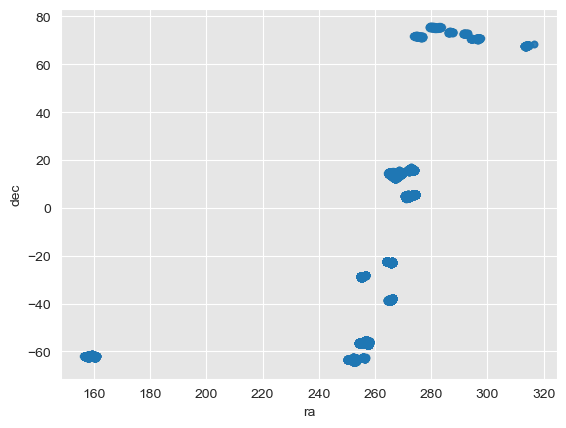

In [6]:
Train_Valid_Dataset.plot(kind = "scatter", x = "ra", y = "dec", alpha = 0.1)

<Axes: xlabel='teff_gspphot', ylabel='mh_gspphot'>

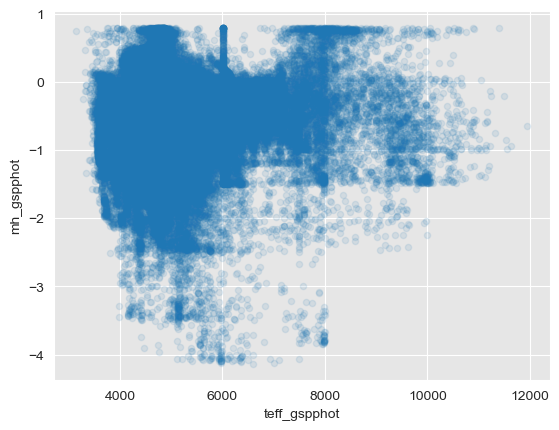

In [7]:
Train_Valid_Dataset.plot(kind = "scatter", x = "teff_gspphot", y = "mh_gspphot", alpha = 0.1)

<Axes: xlabel='teff_gspphot', ylabel='mass_flame'>

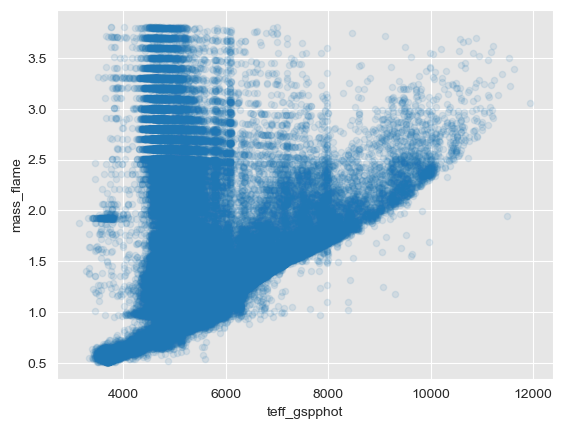

In [8]:
Train_Valid_Dataset.plot(kind = "scatter", x = "teff_gspphot", y = "mass_flame", alpha = 0.1)

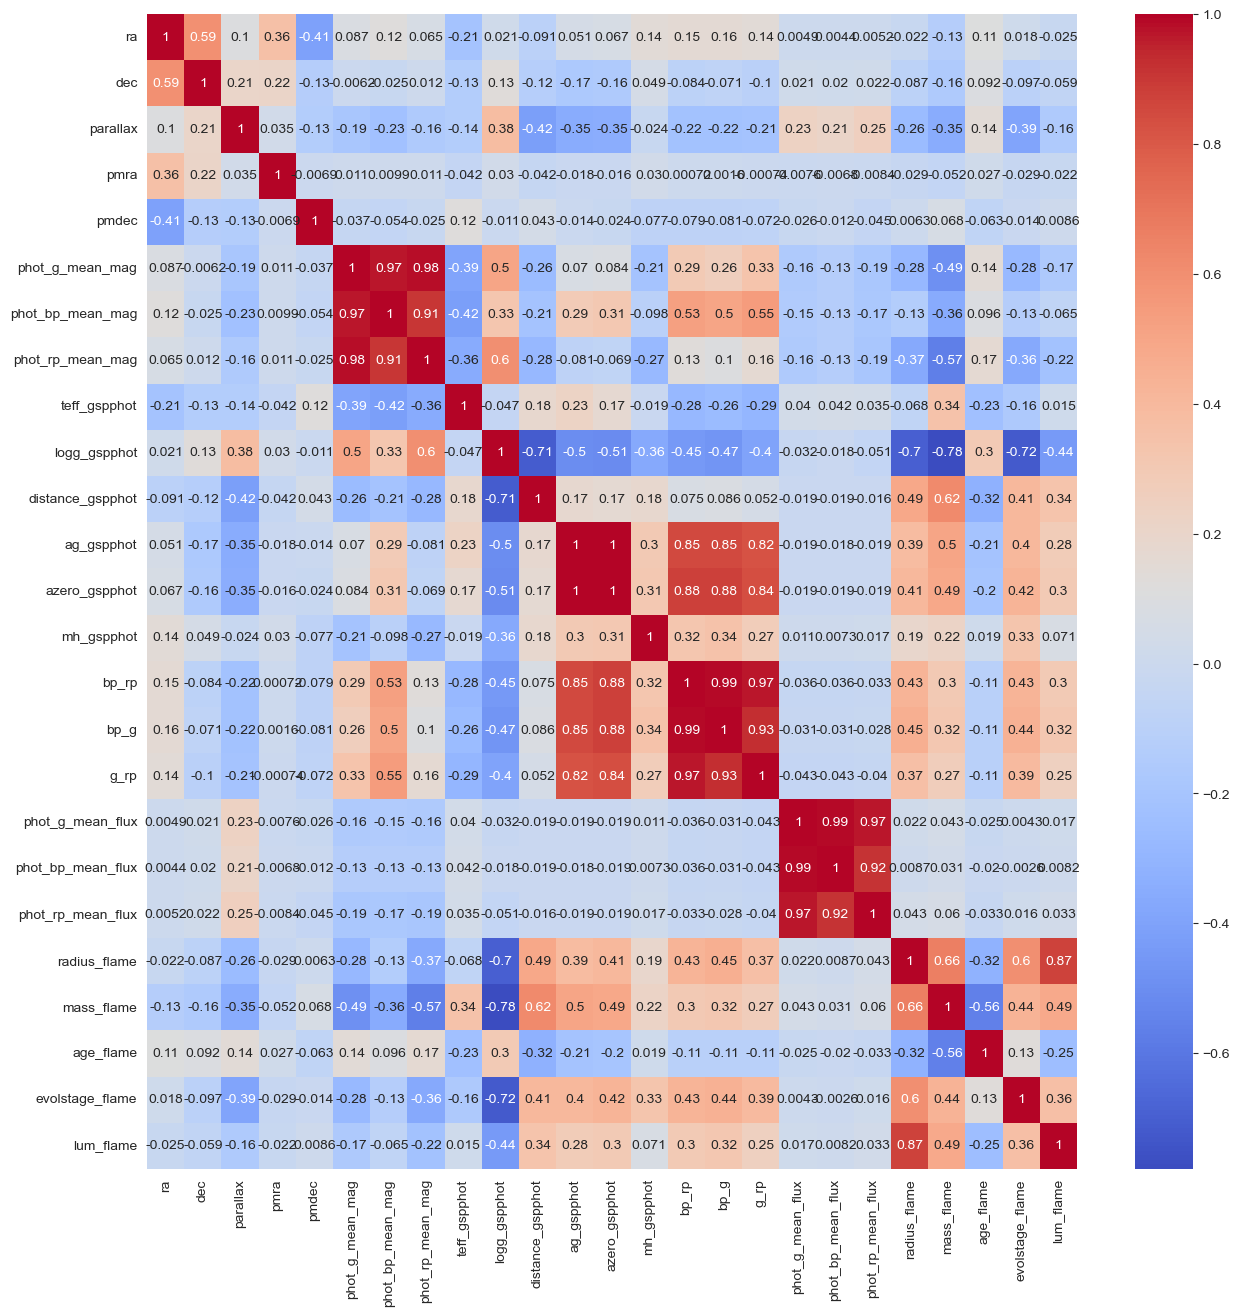

In [9]:
plt.figure(figsize = (15,15))
sns.heatmap(Train_Valid_Dataset.corr(), annot = True, cmap = "coolwarm")  
plt.show()

<Figure size 1500x1500 with 0 Axes>

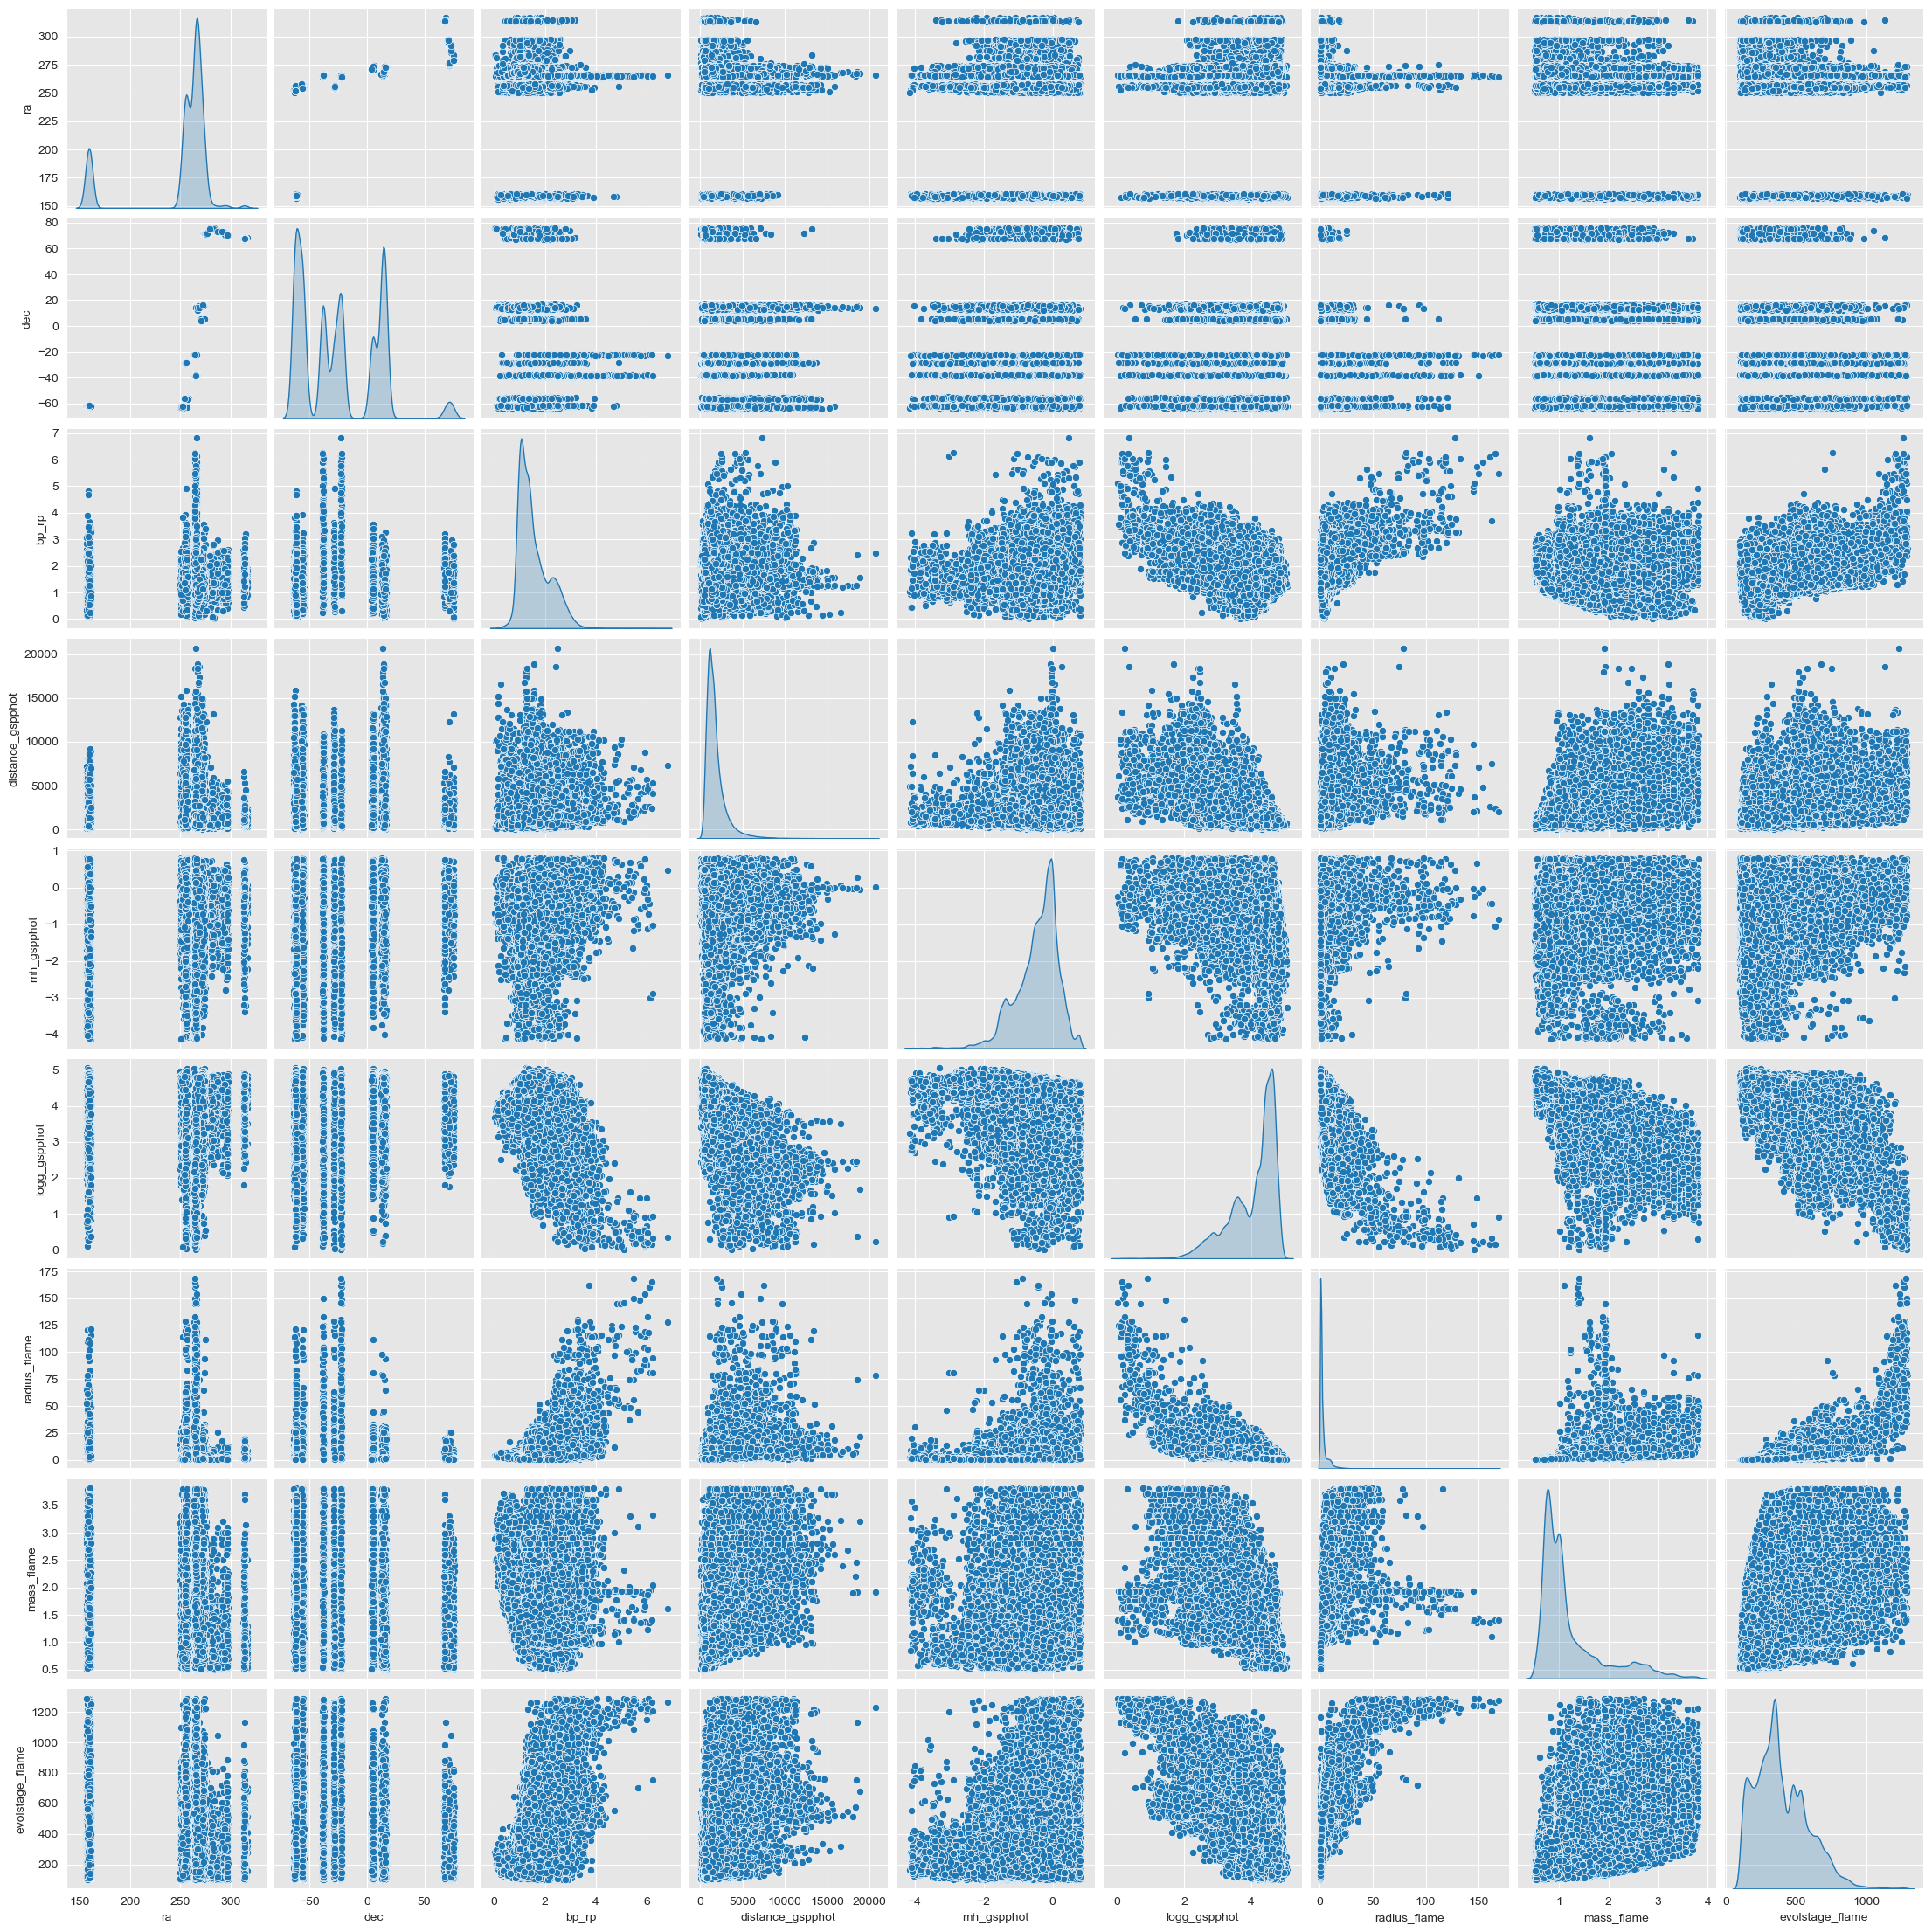

In [10]:
plt.figure(figsize = (15,15))
sns.pairplot(Train_Valid_Dataset[["ra", "dec", "bp_rp", "distance_gspphot", "mh_gspphot", "logg_gspphot", "radius_flame", "mass_flame", "evolstage_flame"]], diag_kind = "kde")
plt.show()

array([[<Axes: title={'center': 'ra'}>, <Axes: title={'center': 'dec'}>,
        <Axes: title={'center': 'parallax'}>,
        <Axes: title={'center': 'pmra'}>,
        <Axes: title={'center': 'pmdec'}>],
       [<Axes: title={'center': 'phot_g_mean_mag'}>,
        <Axes: title={'center': 'phot_bp_mean_mag'}>,
        <Axes: title={'center': 'phot_rp_mean_mag'}>,
        <Axes: title={'center': 'teff_gspphot'}>,
        <Axes: title={'center': 'logg_gspphot'}>],
       [<Axes: title={'center': 'distance_gspphot'}>,
        <Axes: title={'center': 'ag_gspphot'}>,
        <Axes: title={'center': 'azero_gspphot'}>,
        <Axes: title={'center': 'mh_gspphot'}>,
        <Axes: title={'center': 'bp_rp'}>],
       [<Axes: title={'center': 'bp_g'}>,
        <Axes: title={'center': 'g_rp'}>,
        <Axes: title={'center': 'phot_g_mean_flux'}>,
        <Axes: title={'center': 'phot_bp_mean_flux'}>,
        <Axes: title={'center': 'phot_rp_mean_flux'}>],
       [<Axes: title={'center': 'radius

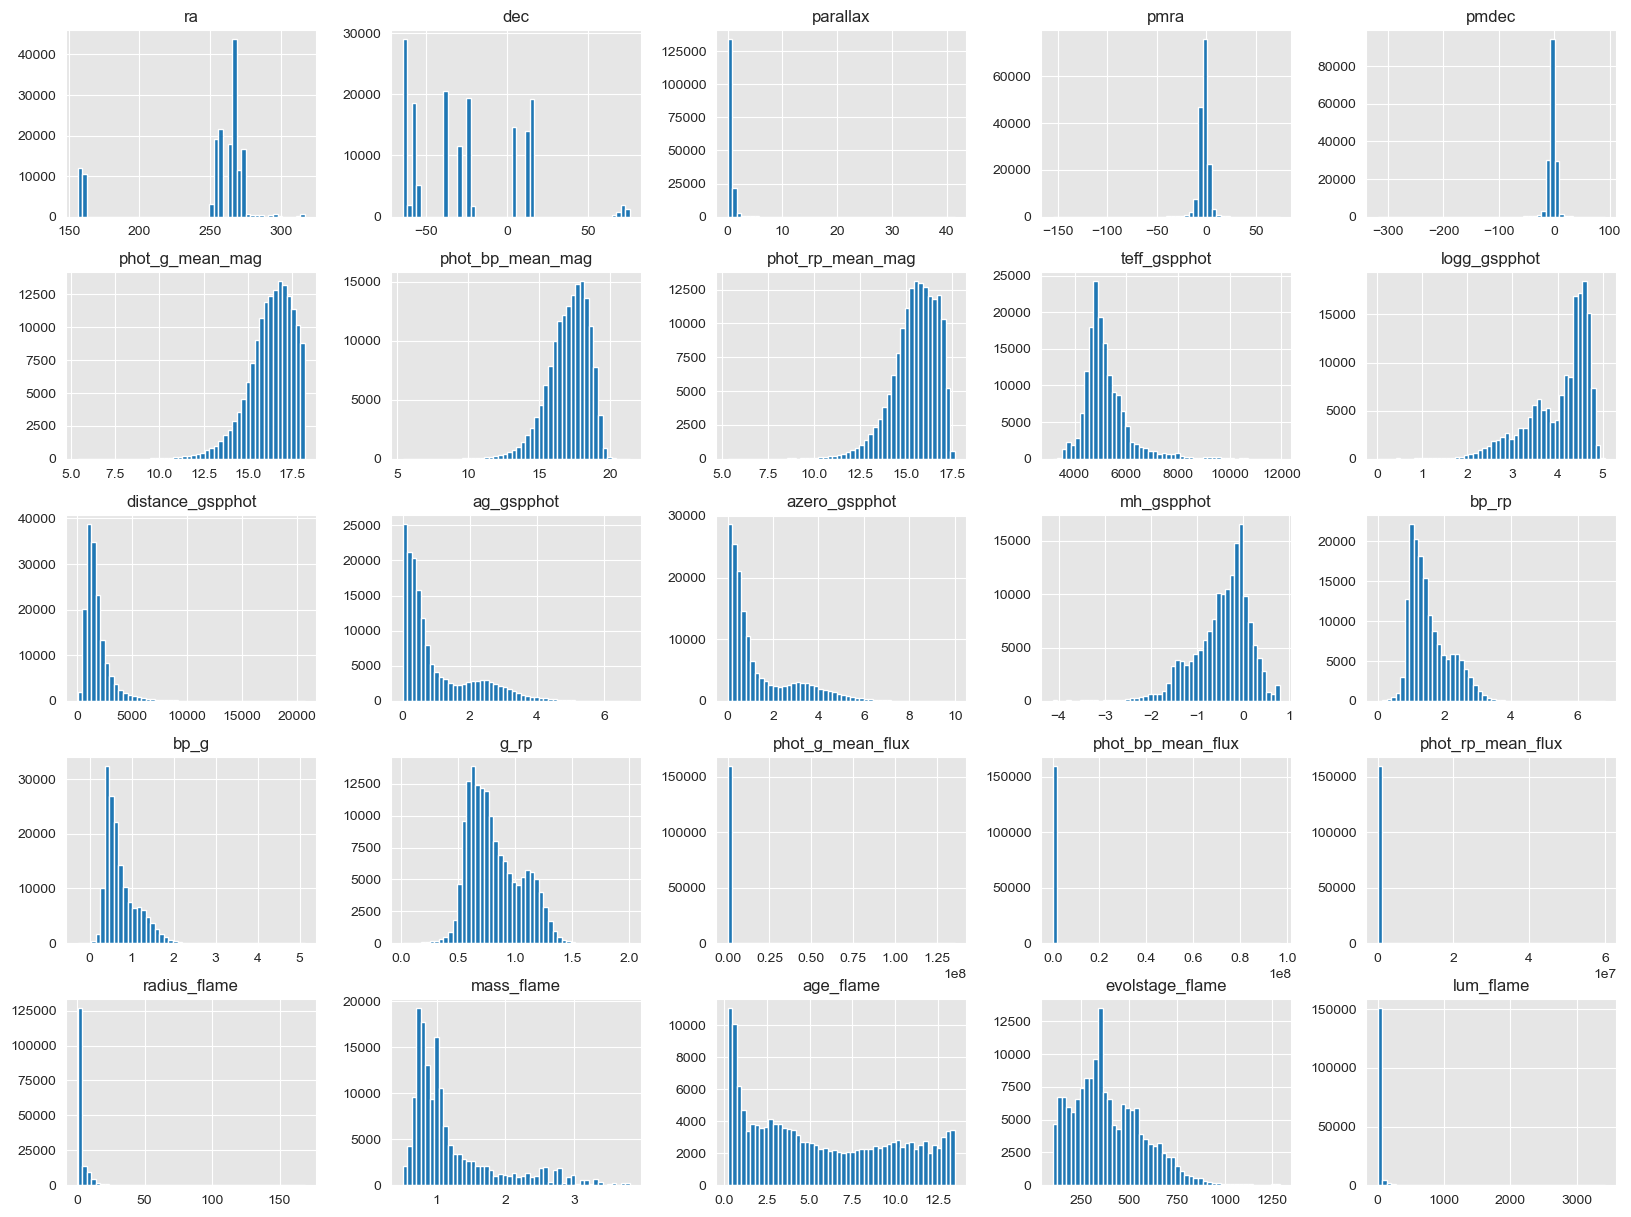

In [11]:
Train_Valid_Dataset.loc[:, Train_Valid_Dataset.columns != "evolstage_flame && age_flame && lum_flame"].hist(bins = 50, figsize = (20,15))

In [12]:
Train_Valid_Dataset.iloc[:, :22].info()

<class 'pandas.core.frame.DataFrame'>
Index: 160000 entries, 4471678266502327936 to 4498884272978886528
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ra                 160000 non-null  float64
 1   dec                160000 non-null  float64
 2   parallax           160000 non-null  float64
 3   pmra               160000 non-null  float64
 4   pmdec              160000 non-null  float64
 5   phot_g_mean_mag    160000 non-null  float64
 6   phot_bp_mean_mag   160000 non-null  float64
 7   phot_rp_mean_mag   160000 non-null  float64
 8   teff_gspphot       160000 non-null  float64
 9   logg_gspphot       160000 non-null  float64
 10  distance_gspphot   160000 non-null  float64
 11  ag_gspphot         160000 non-null  float64
 12  azero_gspphot      160000 non-null  float64
 13  mh_gspphot         160000 non-null  float64
 14  bp_rp              160000 non-null  float64
 15  bp_g               160000

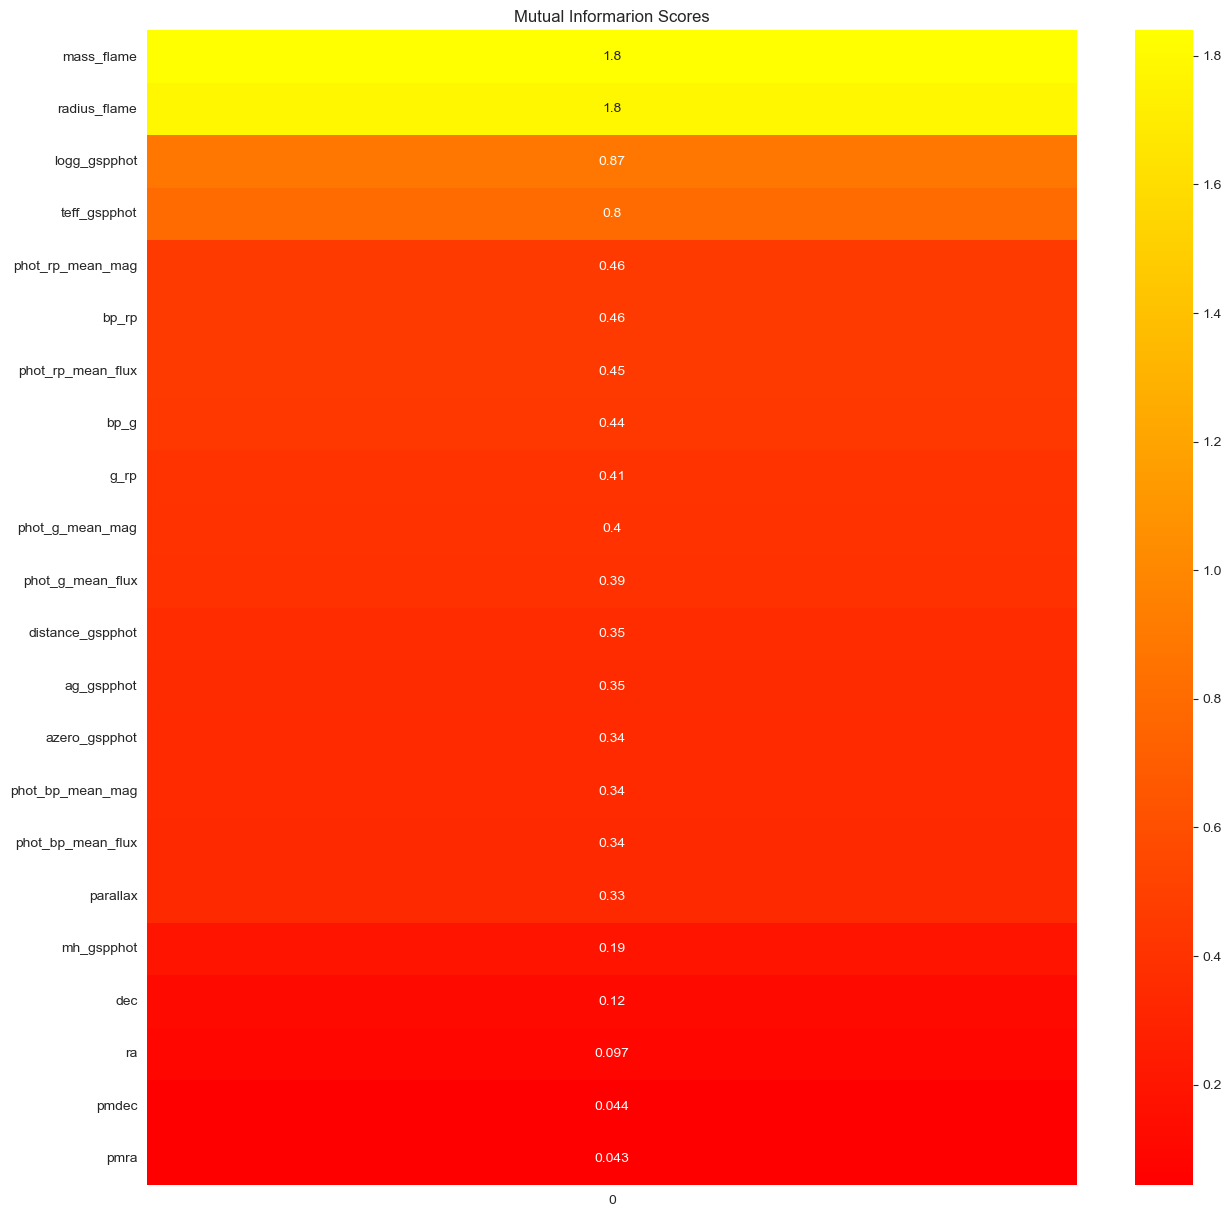

In [13]:
plt.figure(figsize = (15,15))
mass_flame = make_mi_scores(Train_Valid_Dataset.iloc[:, :22], Train_Valid_Dataset.lum_flame, "auto")
plot_mi_scores(mass_flame)
plt.show()

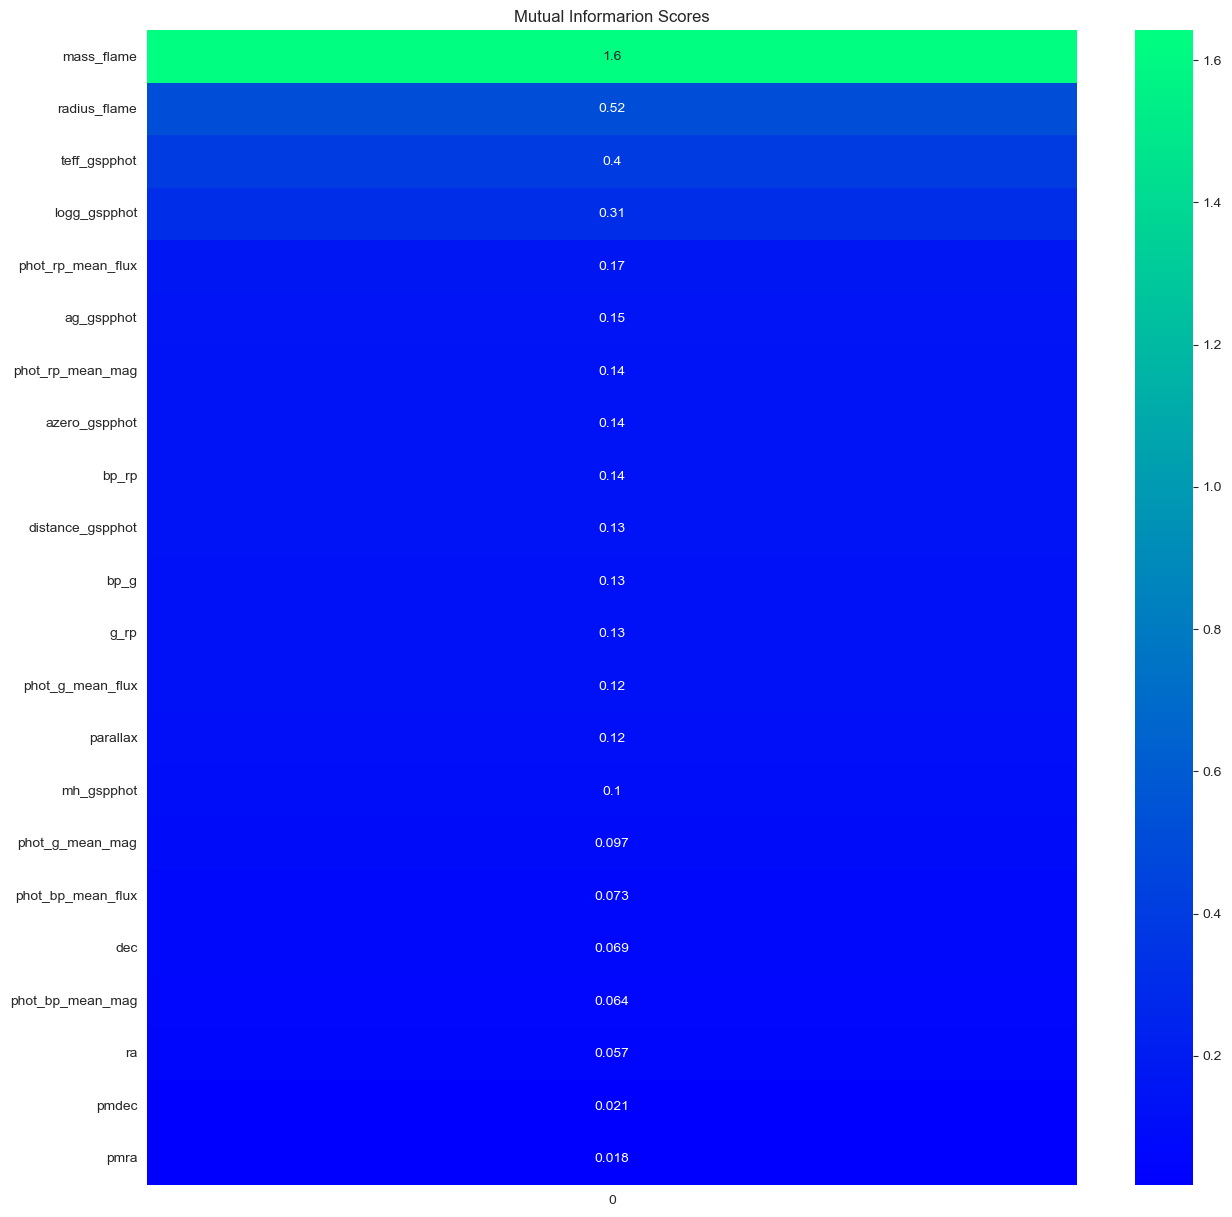

In [14]:
plt.figure(figsize = (15,15))
age_flame = make_mi_scores(Train_Valid_Dataset.iloc[:, :22], Train_Valid_Dataset.age_flame, "auto")
plot_mi_scores(age_flame, cmap = "winter")
plt.show()

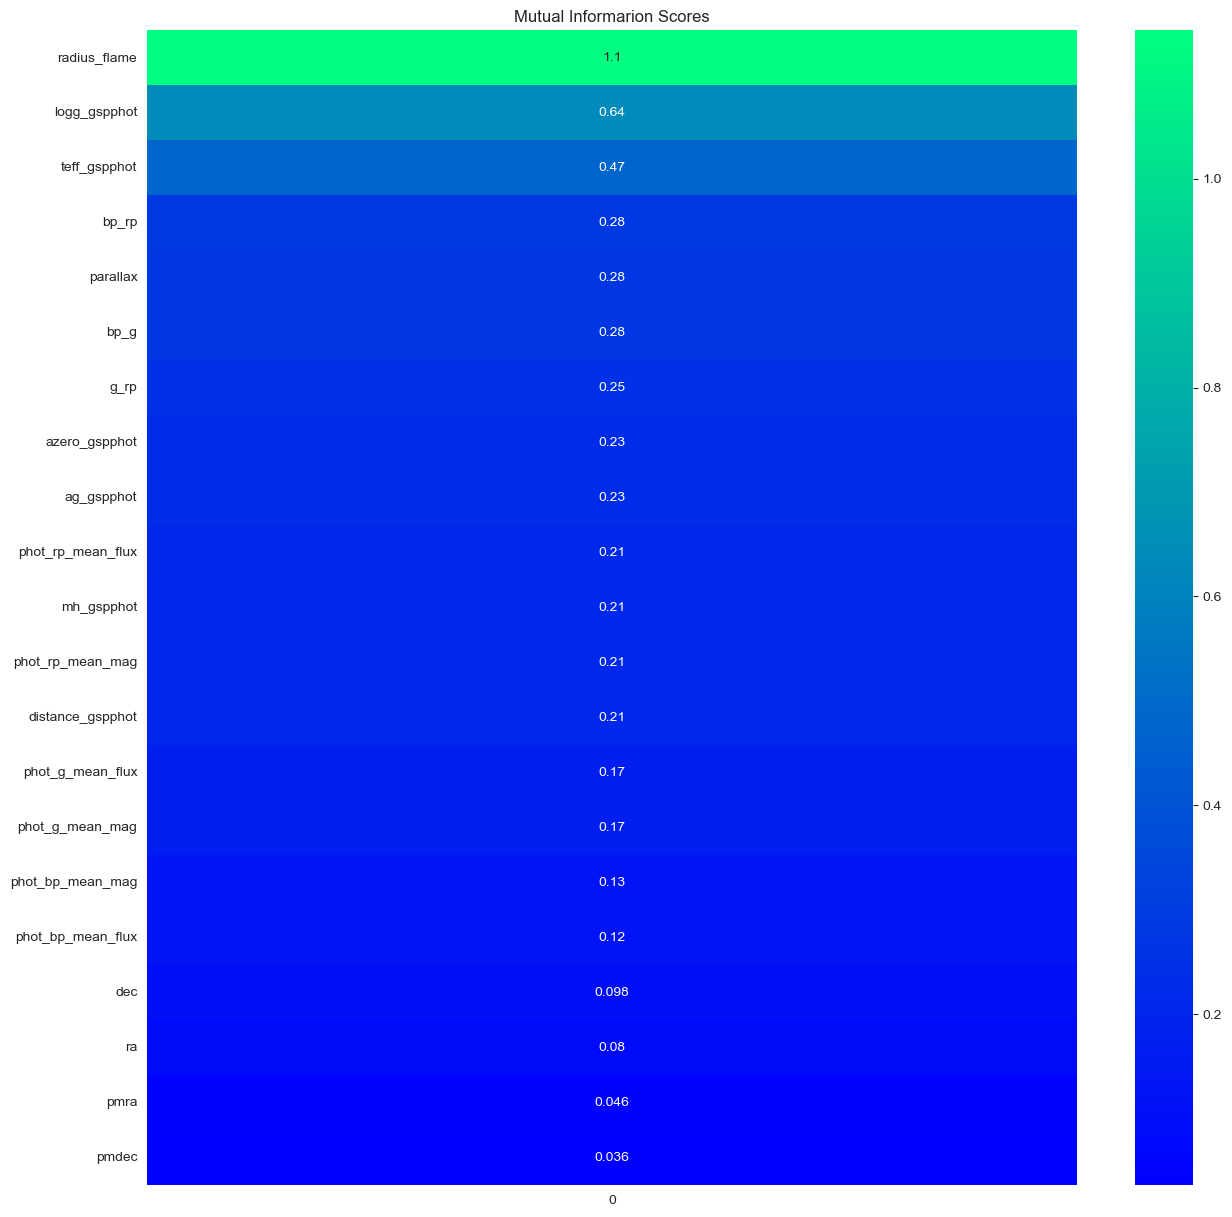

In [15]:
plt.figure(figsize = (15,15))
evolstage_flame = make_mi_scores(Train_Valid_Dataset.iloc[:, :21], Train_Valid_Dataset.evolstage_flame, "auto")
plot_mi_scores(evolstage_flame, cmap = "winter")
plt.show()

In [16]:
Train_Dataset, Valid_Dataset = train_test_split(Train_Valid_Dataset, test_size = 0.2, random_state = 42)
Features, Targets = Train_Dataset.iloc[:, :22], Train_Dataset.iloc[:, 22:]
Valid_Features, Valid_Targets = Valid_Dataset.iloc[:, :22], Valid_Dataset.iloc[:, 22:]
Features.info(), Targets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128000 entries, 4116837719295897088 to 5917245030061911168
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ra                 128000 non-null  float64
 1   dec                128000 non-null  float64
 2   parallax           128000 non-null  float64
 3   pmra               128000 non-null  float64
 4   pmdec              128000 non-null  float64
 5   phot_g_mean_mag    128000 non-null  float64
 6   phot_bp_mean_mag   128000 non-null  float64
 7   phot_rp_mean_mag   128000 non-null  float64
 8   teff_gspphot       128000 non-null  float64
 9   logg_gspphot       128000 non-null  float64
 10  distance_gspphot   128000 non-null  float64
 11  ag_gspphot         128000 non-null  float64
 12  azero_gspphot      128000 non-null  float64
 13  mh_gspphot         128000 non-null  float64
 14  bp_rp              128000 non-null  float64
 15  bp_g               128000

(None, None)

In [17]:
Normalised_Features = MinMaxScaler().fit_transform(Features)
Normalised_Features = pd.DataFrame(Normalised_Features, columns = Features.columns, index = Features.index)
Normalised_Features.describe()

ra       dec  parallax      pmra     pmdec  phot_g_mean_mag  \
count 128000.00 128000.00 128000.00 128000.00 128000.00        128000.00   
mean       0.58      0.28      0.01      0.61      0.81             0.85   
std        0.23      0.23      0.01      0.02      0.02             0.10   
min        0.00      0.00      0.00      0.00      0.00             0.00   
25%        0.62      0.06      0.00      0.60      0.80             0.79   
50%        0.68      0.25      0.01      0.61      0.81             0.86   
75%        0.69      0.50      0.02      0.62      0.82             0.92   
max        1.00      1.00      1.00      1.00      1.00             1.00   

       phot_bp_mean_mag  phot_rp_mean_mag  teff_gspphot  logg_gspphot  ...  \
count         128000.00         128000.00     128000.00     128000.00  ...   
mean               0.73              0.82          0.23          0.80  ...   
std                0.09              0.10          0.10          0.14  ...   
min                0.00              0.00          0.00          0.00  ...   
25%                0.68              0.77          0.18          0.72  ...   
50%                0.74              0.84          0.21          0.86  ...   
75%                0.80              0.90          0.27          0.91  ...   
max                1.00              1.00          1.00          1.00  ...   

       azero_gspphot  mh_gspphot     bp_rp      bp_g      g_rp  \
count      128000.00   128000.00 128000.00 128000.00 128000.00   
mean            0.13        0.75      0.23      0.16      0.40   
std             0.15        0.12      0.09      0.07      0.12   
min             0.00        0.00      0.00      0.00      0.00   
25%             0.03        0.68      0.16      0.11      0.31   
50%             0.07        0.77      0.20      0.14      0.38   
75%             0.19        0.83      0.28      0.20      0.49   
max             1.00        1.00      1.00      1.00      1.00   

       phot_g_mean_flux  phot_bp_mean_flux  phot_rp_mean_flux  radius_flame  \
count         128000.00          128000.00          128000.00     128000.00   
mean               0.00               0.00               0.00          0.02   
std                0.00               0.00               0.00          0.03   
min                0.00               0.00               0.00          0.00   
25%                0.00               0.00               0.00          0.00   
50%                0.00               0.00               0.00          0.01   
75%                0.00               0.00               0.00          0.02   
max                1.00               1.00               1.00          1.00   

       mass_flame  
count   128000.00  
mean         0.21  
std          0.20  
min          0.00  
25%          0.08  
50%          0.14  
75%          0.26  
max          1.00  

[8 rows x 22 columns]

In [18]:
Valid_Normalised_Features = MinMaxScaler().fit_transform(Valid_Features)
Valid_Normalised_Features = pd.DataFrame(Valid_Normalised_Features, columns = Valid_Features.columns, index = Valid_Features.index)
Valid_Normalised_Features.describe()

ra      dec  parallax     pmra    pmdec  phot_g_mean_mag  \
count 32000.00 32000.00  32000.00 32000.00 32000.00         32000.00   
mean      0.58     0.28      0.04     0.76     0.62             0.84   
std       0.24     0.24      0.04     0.02     0.02             0.11   
min       0.00     0.00      0.00     0.00     0.00             0.00   
25%       0.62     0.06      0.01     0.75     0.61             0.78   
50%       0.68     0.25      0.03     0.76     0.62             0.85   
75%       0.69     0.50      0.05     0.77     0.63             0.92   
max       1.00     1.00      1.00     1.00     1.00             1.00   

       phot_bp_mean_mag  phot_rp_mean_mag  teff_gspphot  logg_gspphot  ...  \
count          32000.00          32000.00      32000.00      32000.00  ...   
mean               0.74              0.82          0.23          0.80  ...   
std                0.10              0.10          0.11          0.14  ...   
min                0.00              0.00          0.00          0.00  ...   
25%                0.68              0.77          0.17          0.71  ...   
50%                0.75              0.84          0.21          0.85  ...   
75%                0.82              0.90          0.27          0.90  ...   
max                1.00              1.00          1.00          1.00  ...   

       azero_gspphot  mh_gspphot    bp_rp     bp_g     g_rp  phot_g_mean_flux  \
count       32000.00    32000.00 32000.00 32000.00 32000.00          32000.00   
mean            0.13        0.75     0.24     0.21     0.40              0.00   
std             0.15        0.12     0.10     0.08     0.12              0.01   
min             0.00        0.00     0.00     0.00     0.00              0.00   
25%             0.03        0.68     0.16     0.15     0.31              0.00   
50%             0.07        0.77     0.21     0.19     0.38              0.00   
75%             0.19        0.83     0.30     0.25     0.49              0.00   
max             1.00        1.00     1.00     1.00     1.00              1.00   

       phot_bp_mean_flux  phot_rp_mean_flux  radius_flame  mass_flame  
count           32000.00           32000.00      32000.00    32000.00  
mean                0.00               0.00          0.02        0.22  
std                 0.01               0.01          0.04        0.20  
min                 0.00               0.00          0.00        0.00  
25%                 0.00               0.00          0.00        0.08  
50%                 0.00               0.00          0.01        0.15  
75%                 0.00               0.00          0.02        0.26  
max                 1.00               1.00          1.00        1.00  

[8 rows x 22 columns]

<Axes: >

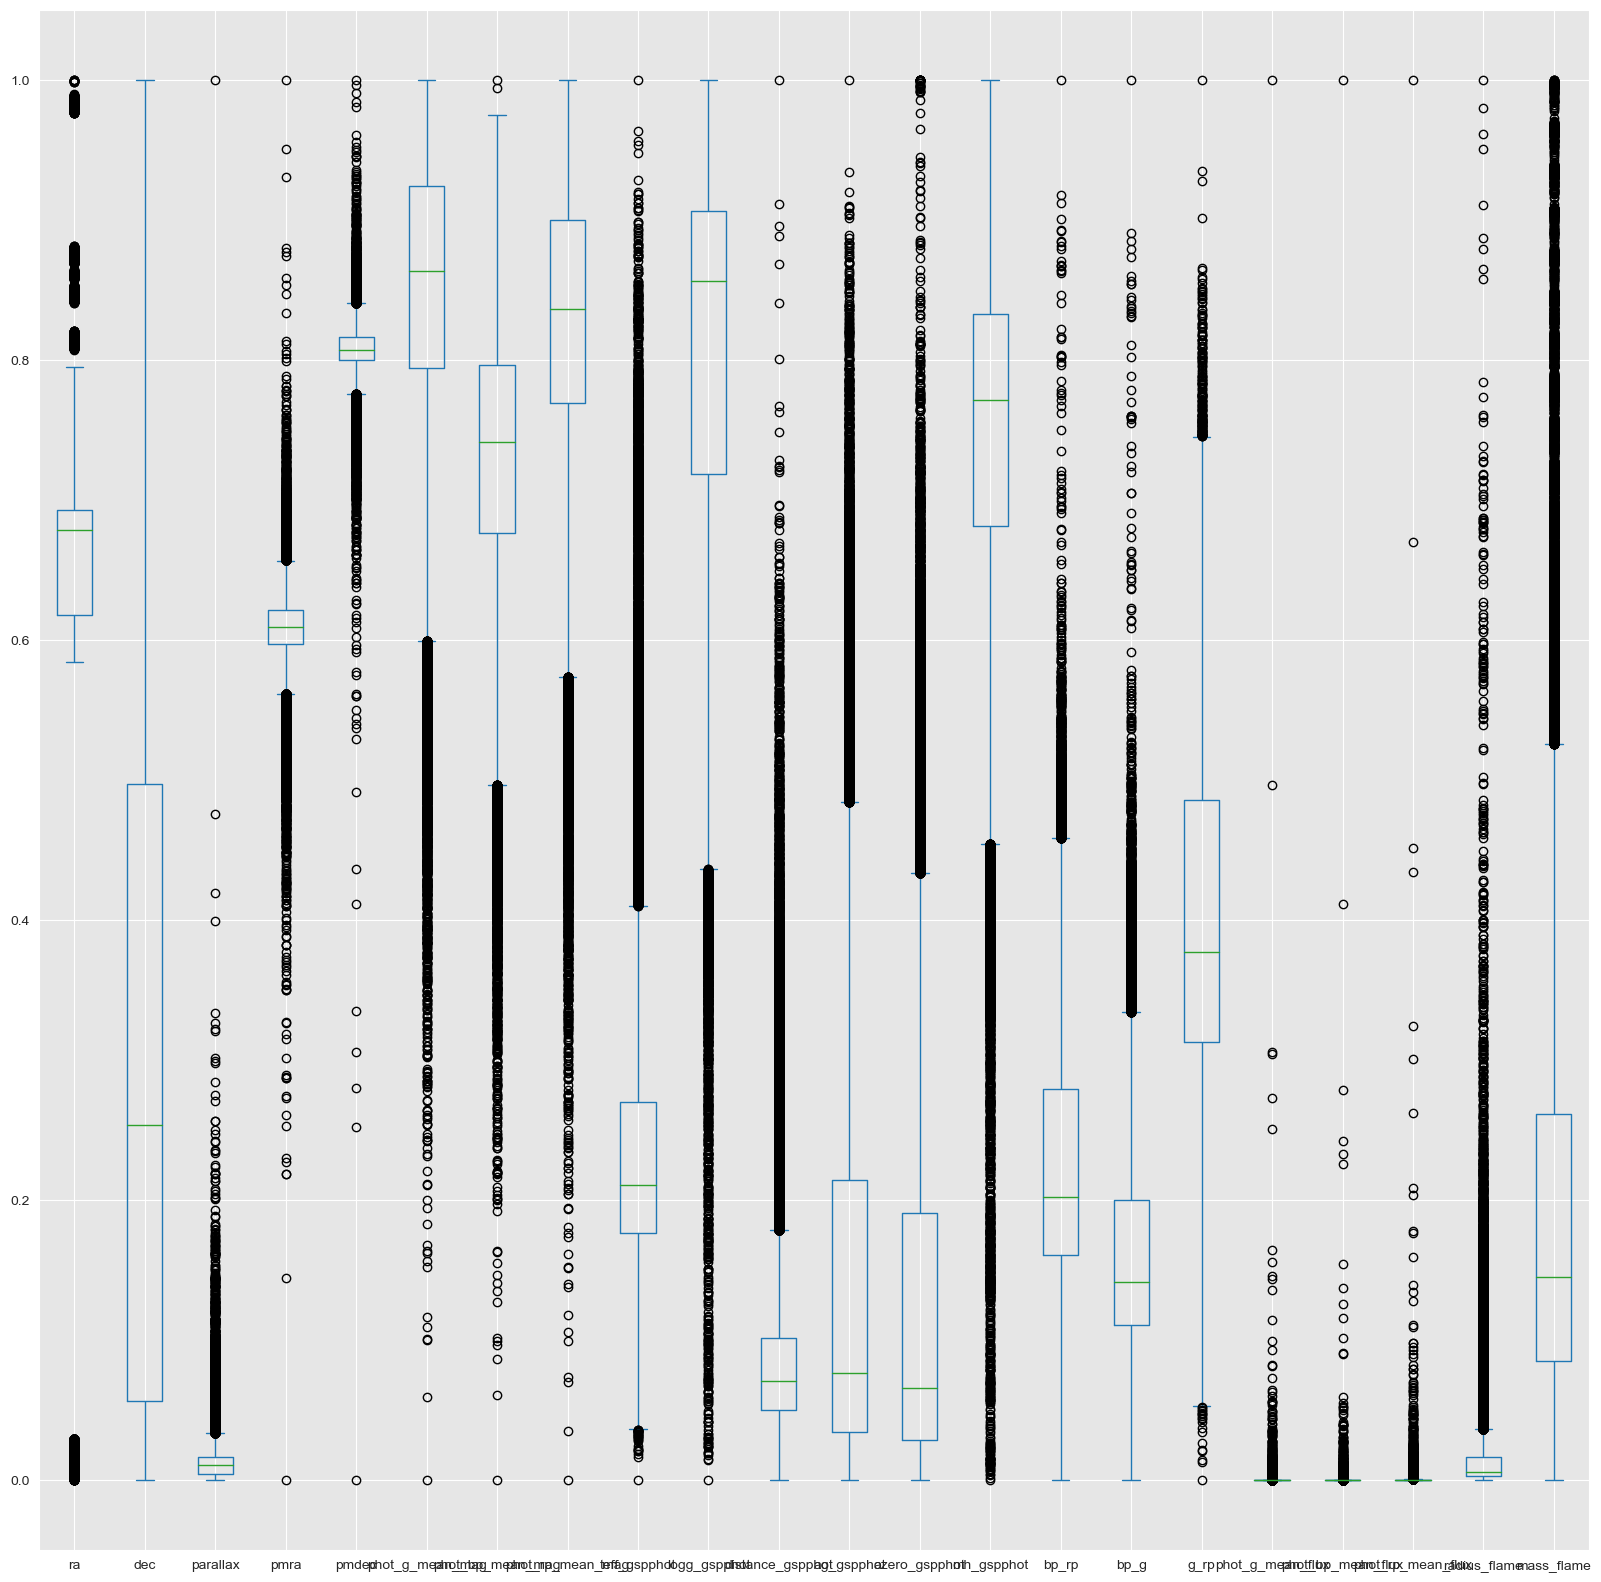

In [19]:
Normalised_Features.plot(kind = "box", figsize = (20,20))

In [20]:
Normalised_Features

ra  dec  parallax  pmra  pmdec  phot_g_mean_mag  \
SOURCE_ID                                                               
4116837719295897088 0.67 0.30      0.00  0.61   0.80             0.91   
5253659590531074176 0.02 0.02      0.02  0.53   0.82             0.98   
5961516964516573184 0.68 0.18      0.00  0.61   0.80             0.88   
4499069398947781888 0.73 0.58      0.01  0.61   0.80             0.94   
4498833759860500096 0.72 0.57      0.02  0.61   0.78             0.96   
...                  ...  ...       ...   ...    ...              ...   
4500128542179566848 0.70 0.57      0.01  0.62   0.80             0.66   
4116912456056232960 0.68 0.30      0.01  0.62   0.81             0.99   
2268452230822170240 0.79 0.99      0.03  0.56   0.78             0.92   
5961534870319200512 0.68 0.19      0.00  0.60   0.80             0.98   
5917245030061911168 0.63 0.05      0.01  0.62   0.80             0.87   

                     phot_bp_mean_mag  phot_rp_mean_mag  teff_gspphot  \
SOURCE_ID                                                               
4116837719295897088              0.81              0.86          0.19   
5253659590531074176              0.85              0.95          0.13   
5961516964516573184              0.78              0.84          0.51   
4499069398947781888              0.79              0.93          0.19   
4498833759860500096              0.81              0.94          0.14   
...                               ...               ...           ...   
4500128542179566848              0.57              0.63          0.19   
4116912456056232960              0.85              0.94          0.12   
2268452230822170240              0.79              0.90          0.15   
5961534870319200512              0.87              0.93          0.15   
5917245030061911168              0.73              0.86          0.23   

                     logg_gspphot  ...  azero_gspphot  mh_gspphot  bp_rp  \
SOURCE_ID                          ...                                     
4116837719295897088          0.71  ...           0.35        0.86   0.36   
5253659590531074176          0.90  ...           0.08        0.84   0.27   
5961516964516573184          0.76  ...           0.47        1.00   0.33   
4499069398947781888          0.93  ...           0.02        0.72   0.18   
4498833759860500096          0.92  ...           0.00        0.66   0.19   
...                           ...  ...            ...         ...    ...   
4500128542179566848          0.58  ...           0.05        0.81   0.19   
4116912456056232960          0.88  ...           0.15        0.46   0.30   
2268452230822170240          0.93  ...           0.07        0.90   0.25   
5961534870319200512          0.89  ...           0.31        0.67   0.37   
5917245030061911168          0.87  ...           0.02        0.69   0.16   

                     bp_g  g_rp  phot_g_mean_flux  phot_bp_mean_flux  \
SOURCE_ID                                                              
4116837719295897088  0.28  0.55              0.00               0.00   
5253659590531074176  0.20  0.46              0.00               0.00   
5961516964516573184  0.25  0.55              0.00               0.00   
4499069398947781888  0.13  0.34              0.00               0.00   
4498833759860500096  0.14  0.36              0.00               0.00   
...                   ...   ...               ...                ...   
4500128542179566848  0.14  0.36              0.00               0.00   
4116912456056232960  0.20  0.58              0.00               0.00   
2268452230822170240  0.18  0.43              0.00               0.00   
5961534870319200512  0.27  0.59              0.00               0.00   
5917245030061911168  0.11  0.30              0.00               0.00   

                     phot_rp_mean_flux  radius_flame  mass_flame  
SOURCE_ID                                                         
4116837719295897088               0.00          0.01        0.

In [21]:
Valid_Normalised_Features

ra  dec  parallax  pmra  pmdec  phot_g_mean_mag  \
SOURCE_ID                                                               
4498719758551163136 0.73 0.57      0.05  0.80   0.66             0.98   
5961446428335476096 0.68 0.18      0.03  0.77   0.63             0.84   
4116856995100190720 0.68 0.29      0.01  0.80   0.63             0.81   
5917274476358972288 0.63 0.06      0.05  0.79   0.63             0.86   
4499357921968630528 0.70 0.56      0.06  0.77   0.66             0.81   
...                  ...  ...       ...   ...    ...              ...   
6030047497051387648 0.62 0.25      0.05  0.76   0.63             0.95   
5961515594498617600 0.68 0.19      0.01  0.76   0.62             0.83   
5961493879136727680 0.68 0.19      0.04  0.77   0.62             0.80   
5253692855095453312 0.02 0.02      0.02  0.75   0.64             0.73   
5961471236068450432 0.68 0.18      0.04  0.69   0.58             0.78   

                     phot_bp_mean_mag  phot_rp_mean_mag  teff_gspphot  \
SOURCE_ID                                                               
4498719758551163136              0.86              0.97          0.12   
5961446428335476096              0.78              0.80          0.43   
4116856995100190720              0.76              0.77          0.23   
5917274476358972288              0.74              0.86          0.24   
4499357921968630528              0.70              0.82          0.26   
...                               ...               ...           ...   
6030047497051387648              0.81              0.93          0.15   
5961515594498617600              0.80              0.79          0.17   
5961493879136727680              0.70              0.79          0.49   
5253692855095453312              0.61              0.74          0.91   
5961471236068450432              0.68              0.76          0.27   

                     logg_gspphot  ...  azero_gspphot  mh_gspphot  bp_rp  \
SOURCE_ID                          ...                                     
4498719758551163136          0.96  ...           0.03        0.57   0.23   
5961446428335476096          0.78  ...           0.45        0.84   0.38   
4116856995100190720          0.68  ...           0.37        0.82   0.38   
5917274476358972288          0.91  ...           0.04        0.73   0.17   
4499357921968630528          0.91  ...           0.04        0.71   0.16   
...                           ...  ...            ...         ...    ...   
6030047497051387648          0.87  ...           0.02        0.63   0.20   
5961515594498617600          0.61  ...           0.41        0.87   0.43   
5961493879136727680          0.69  ...           0.24        0.76   0.22   
5253692855095453312          0.84  ...           0.18        0.72   0.12   
5961471236068450432          0.72  ...           0.16        0.66   0.24   

                     bp_g  g_rp  phot_g_mean_flux  phot_bp_mean_flux  \
SOURCE_ID                                                              
4498719758551163136  0.20  0.39              0.00               0.00   
5961446428335476096  0.32  0.57              0.00               0.00   
4116856995100190720  0.32  0.58              0.00               0.00   
5917274476358972288  0.16  0.31              0.00               0.00   
4499357921968630528  0.15  0.30              0.00               0.00   
...                   ...   ...               ...                ...   
6030047497051387648  0.14  0.46              0.00               0.00   
5961515594498617600  0.38  0.61              0.00               0.00   
5961493879136727680  0.19  0.40              0.00               0.00   
5253692855095453312  0.12  0.25              0.00               0.00   
5961471236068450432  0.20  0.42              0.00               0.00   

                     phot_rp_mean_flux  radius_flame  mass_flame  
SOURCE_ID                                                         
4498719758551163136               0.00          0.00        0.

In [22]:
Regressor = LazyRegressor(verbose = 0, ignore_warnings = True, custom_metric = None)
Models, Predictions = Regressor.fit(Normalised_Features, Valid_Normalised_Features, Targets, Valid_Targets)
Models

  0%|          | 0/42 [00:00<?, ?it/s]

100%|██████████| 42/42 [23:32<00:00, 33.64s/it] 


Adjusted R-Squared  \
Model                                                             
ExtraTreesRegressor                                        0.86   
RandomForestRegressor                                      0.85   
BaggingRegressor                                           0.84   
XGBRegressor                                               0.82   
DecisionTreeRegressor                                      0.74   
ExtraTreeRegressor                                         0.69   
OrthogonalMatchingPursuit                                  0.53   
ElasticNet                                                 0.47   
LassoLars                                                  0.40   
Lasso                                                      0.40   
MLPRegressor                                               0.09   
DummyRegressor                                            -0.00   
Ridge                                                     -0.02   
KNeighborsRegressor                                       -0.28   
RidgeCV                                                   -0.35   
LinearRegression                                   -52083534.18   
TransformedTargetRegressor                         -52083534.18   
RANSACRegressor                                -674925531182.38   
Lars                       -81834325774282335556255967346688.00   

                                                      R-Squared  \
Model                                                             
ExtraTreesRegressor                                        0.86   
RandomForestRegressor                                      0.85   
BaggingRegressor                                           0.84   
XGBRegressor                                               0.82   
DecisionTreeRegressor                                      0.74   
ExtraTreeRegressor                                         0.69   
OrthogonalMatchingPursuit                                  0.53   
ElasticNet                                                 0.47   
LassoLars                                                  0.40   
Lasso                                                      0.40   
MLPRegressor                                               0.09   
DummyRegressor                                            -0.00   
Ridge                                                     -0.02   
KNeighborsRegressor                                       -0.28   
RidgeCV                                                   -0.35   
LinearRegression                                   -52047725.63   
TransformedTargetRegressor                         -52047725.63   
RANSACRegressor                                -674461505378.89   
Lars                       -81778062917098221793138377228288.00   

                                             RMSE  Time Taken  
Model                                                          
ExtraTreesRegressor                         33.68      188.71  
RandomForestRegressor                       35.60      977.78  
BaggingRegressor                            36.79      100.97  
XGBRegressor                                38.94        1.60  
DecisionTreeRegressor                       45.42       13.86  
ExtraTreeRegressor                          49.62        1.67  
OrthogonalMatchingPursuit                   76.06        0.12  
ElasticNet                                  80.09        0.40  
LassoLars                                   97.74        0.13  
Lasso                                       97.83        3.11  
MLPRegressor                                86.39      117.89  
DummyRegressor                             114.99        0.09  
Ridge                                      150.41        0.13  
KNeighborsRegressor                        157.47        2.34  
RidgeCV                                    181.60        0.26  
LinearRegression                        891641.43        0.18  
TransformedTargetRegressor              891641.43        0.13  
RANSACRegress

In [24]:
Regressor = LazyRegressor(verbose = 0, ignore_warnings = True, custom_metric = None)
Models, Predictions = Regressor.fit(Normalised_Features, Valid_Normalised_Features, Targets, Valid_Targets)
Models

100%|██████████| 42/42 [08:54<00:00, 12.72s/it]


Adjusted R-Squared  \
Model                                                                
ExtraTreesRegressor                                           0.51   
RandomForestRegressor                                         0.47   
BaggingRegressor                                              0.45   
MLPRegressor                                                  0.44   
OrthogonalMatchingPursuit                                     0.38   
XGBRegressor                                                  0.36   
ElasticNet                                                    0.29   
Lasso                                                         0.25   
LassoLars                                                     0.25   
RidgeCV                                                       0.25   
Ridge                                                         0.25   
DecisionTreeRegressor                                         0.02   
DummyRegressor                                               -0.00   
ExtraTreeRegressor                                           -0.16   
KNeighborsRegressor                                          -0.20   
GaussianProcessRegressor                                     -2.12   
KernelRidge                                                  -2.13   
LinearRegression                                    -3656326174.19   
TransformedTargetRegressor                          -3656326174.19   
RANSACRegressor                                  -1901151721263.71   
Lars                       -11933132008064971851475129815007232.00   

                                                         R-Squared  \
Model                                                                
ExtraTreesRegressor                                           0.51   
RandomForestRegressor                                         0.47   
BaggingRegressor                                              0.45   
MLPRegressor                                                  0.44   
OrthogonalMatchingPursuit                                     0.38   
XGBRegressor                                                  0.36   
ElasticNet                                                    0.30   
Lasso                                                         0.26   
LassoLars                                                     0.26   
RidgeCV                                                       0.25   
Ridge                                                         0.25   
DecisionTreeRegressor                                         0.03   
DummyRegressor                                               -0.00   
ExtraTreeRegressor                                           -0.16   
KNeighborsRegressor                                          -0.20   
GaussianProcessRegressor                                     -2.11   
KernelRidge                                                  -2.12   
LinearRegression                                    -3646727118.10   
TransformedTargetRegressor                          -3646727118.10   
RANSACRegressor                                  -1896160574101.99   
Lars                       -11901803620495354043215798467559424.00   

                                             RMSE  Time Taken  
Model                                                          
ExtraTreesRegressor                         56.40       34.08  
RandomForestRegressor                       58.92      188.53  
BaggingRegressor                            60.79       19.58  
MLPRegressor                                60.49       21.58  
OrthogonalMatchingPursuit                   68.41        0.03  
XGBRegressor                                69.07        1.03  
ElasticNet                                  64.64        0.22  
Lasso                                       66.29        0.85  
LassoLars                                   66.30        0.04  
RidgeCV                                     72.12        0.07  
Ridge                                       72.12        0

In [41]:
import lightning as L
def rmsle(y_true, y_pred):
    return pt.sqrt(pt.mean(pt.square(pt.log1p(y_true) - pt.log1p(y_pred))))

class FeedForwardNetwork(L.LightningModule):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNetwork, self).__init__()

        self.hidden_1 = nn.Linear(input_size, hidden_size)
        self.hidden_2 = nn.Linear(hidden_size, hidden_size)
        self.hidden_3 = nn.Linear(hidden_size, hidden_size)
        self.hidden_4 = nn.Linear(hidden_size, hidden_size)
        self.hidden_5 = nn.Linear(hidden_size, hidden_size)

        self.activation = nn.GELU()

        self.Normalisation1 = nn.BatchNorm1d(hidden_size)
        self.Normalisation2 = nn.BatchNorm1d(hidden_size)
        self.Normalisation3 = nn.BatchNorm1d(hidden_size)
        self.Normalisation4 = nn.BatchNorm1d(hidden_size)
        self.Normalisation5 = nn.BatchNorm1d(hidden_size)

        self.dropout = nn.Dropout(0.45)

        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):

        out = self.hidden_1(x)
        out = self.activation(out)
        out = self.Normalisation1(out)
        out = self.dropout(out)

        out = self.hidden_2(out)
        out = self.activation(out)
        out = self.Normalisation2(out)
        out = self.dropout(out)

        out = self.hidden_3(out)
        out = self.activation(out)
        out = self.Normalisation3(out)
        x = self.dropout(out)

        out = self.hidden_4(out)
        out = self.activation(out)
        out = self.Normalisation4(out)
        x = self.dropout(out)

        out = self.hidden_5(out)
        out = self.activation(out)
        out = self.Normalisation5(out)

        x = self.output(out)

        return x
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = pt.sqrt(F.mse_loss(y_hat, y))
        self.log("train_loss", loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def configure_optimizers(self):
        return pt.optim.Adam(self.parameters(), lr = 0.0005, weight_decay= 0.001)
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = pt.sqrt(F.mse_loss(y_hat, y))
        self.log("val_loss", loss,  on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x,y = batch
        y_hat = self.forward(x)
        loss = pt.sqrt(F.mse_loss(y_hat, y))
        self.log("test_loss", loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x, y = batch
        y_hat = self.forward(x)
        return y_hat

In [42]:
Base_NeuralNetwork = FeedForwardNetwork(22, 128, 3).to("cuda")
summary(Base_NeuralNetwork, (128,22))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 128, 128]           2,944
              GELU-2             [-1, 128, 128]               0
       BatchNorm1d-3             [-1, 128, 128]             256
           Dropout-4             [-1, 128, 128]               0
            Linear-5             [-1, 128, 128]          16,512
              GELU-6             [-1, 128, 128]               0
       BatchNorm1d-7             [-1, 128, 128]             256
           Dropout-8             [-1, 128, 128]               0
            Linear-9             [-1, 128, 128]          16,512
             GELU-10             [-1, 128, 128]               0
      BatchNorm1d-11             [-1, 128, 128]             256
          Dropout-12             [-1, 128, 128]               0
           Linear-13             [-1, 128, 128]          16,512
             GELU-14             [-1, 1

In [43]:
from torch.utils.data import TensorDataset
Train_Features = pt.tensor(Normalised_Features.values, dtype = pt.float32).to("cuda")
Valid_Features = pt.tensor(Valid_Normalised_Features.values, dtype= pt.float32).to("cuda")
Train_Targets = pt.tensor(Targets.values, dtype = pt.float32).to("cuda")
Valid_Target_set = pt.tensor(Valid_Targets.values, dtype = pt.float32).to("cuda")
Train_Dataset = TensorDataset(Train_Features, Train_Targets)
Valid_Dataset = TensorDataset(Valid_Features, Valid_Target_set)
Train_Loader = dataloader.DataLoader(Train_Dataset, batch_size = 128, shuffle = True)
Valid_Loader = dataloader.DataLoader(Valid_Dataset, batch_size = 128, shuffle = False)
Train_Loader, Valid_Loader

(<torch.utils.data.dataloader.DataLoader at 0x1eb94484b50>,
 <torch.utils.data.dataloader.DataLoader at 0x1eb97874990>)

In [44]:
Train_Dataset

In [45]:
for element in Valid_Loader:
    print(element[0].shape, element[1].shape)
    break

torch.Size([128, 22]) torch.Size([128, 3])


In [46]:
# Define the callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
lr_monitor = LearningRateMonitor(logging_interval='step')

Trainier = L.Trainer(max_epochs= 100, callbacks= [early_stopping_callback, lr_monitor])
Trainier.fit(Base_NeuralNetwork, Train_Loader, Valid_Loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type        | Params
------------------------------------------------
0  | hidden_1       | Linear      | 2.9 K 
1  | hidden_2       | Linear      | 16.5 K
2  | hidden_3       | Linear      | 16.5 K
3  | hidden_4       | Linear      | 16.5 K
4  | hidden_5       | Linear      | 16.5 K
5  | activation     | GELU        | 0     
6  | Normalisation1 | BatchNorm1d | 256   
7  | Normalisation2 | BatchNorm1d | 256   
8  | Normalisation3 | BatchNorm1d | 256   
9  | Normalisation4 | BatchNorm1d | 256   
10 | Normalisation5 | BatchNorm1d | 256   
11 | dropout        | Dropout     | 0     
12 | output         | Linear      | 387   
------------------------------------------------
70.7 K    Trainable params
0         Non-trainable params
70.7 K    Total params
0.283     Total estimate

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 215.683


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 69.852 >= min_delta = 0.0. New best score: 145.831


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 92.884 >= min_delta = 0.0. New best score: 52.946


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 11.265 >= min_delta = 0.0. New best score: 41.681


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 3.861 >= min_delta = 0.0. New best score: 37.820


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 2.251 >= min_delta = 0.0. New best score: 35.569


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 35.569. Signaling Trainer to stop.


In [47]:
Trainier.test(Base_NeuralNetwork, Valid_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     38.87979507446289     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 38.87979507446289}]

In [48]:
Predictions = Trainier.predict(Base_NeuralNetwork, Valid_Loader)
Predicted_Values = pt.vstack(Predictions).cpu().detach().numpy()
Predicted_Values.shape

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

(32000, 3)

array([[<Axes: title={'center': 'age_flame'}>,
        <Axes: title={'center': 'evolstage_flame'}>],
       [<Axes: title={'center': 'lum_flame'}>, <Axes: >]], dtype=object)

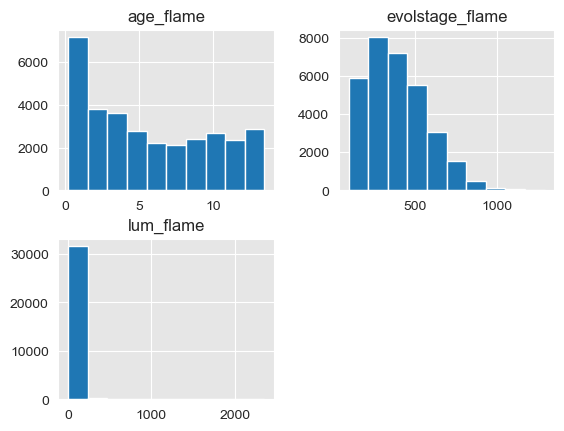

In [49]:
Valid_Targets.hist()

In [50]:
sk.metrics.r2_score(Valid_Targets, Predicted_Values)

0.7028188485870244

In [51]:
np.sqrt(sk.metrics.mean_squared_error(Valid_Targets, Predicted_Values))

42.86530340991566

In [52]:
np.sqrt(sk.metrics.mean_squared_error(Valid_Targets, Predicted_Values))

42.86530340991566

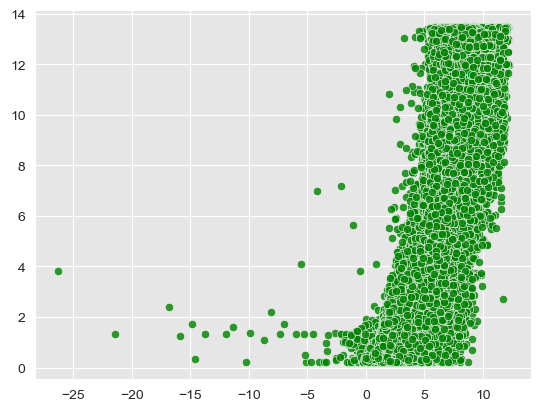

In [53]:
sns.scatterplot(x = Predicted_Values[:, 0], y = Valid_Targets.values[:, 0], alpha = 0.8, color = "green")
plt.show()

<Axes: >

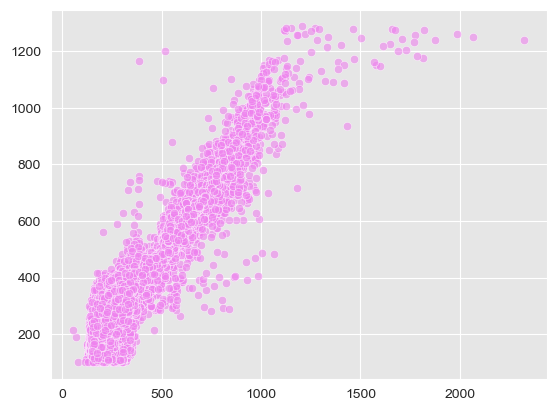

In [54]:
sns.scatterplot(x = Predicted_Values[:, 1], y = Valid_Targets.values[:, 1], alpha = 0.6, color = "violet")

<Axes: >

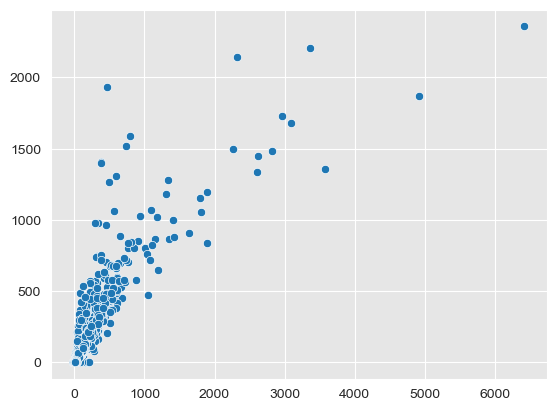

In [55]:
sns.scatterplot(x = Predicted_Values[:, 2], y = Valid_Targets.values[:, 2])